In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install hmmlearn
!pip install pmdarima

     |████████████████████████████████| 368kB 5.8MB/s 
     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 2.1MB 52.1MB/s 
     |████████████████████████████████| 9.5MB 47.1MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator
from fbprophet import Prophet
import statsmodels as sms
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from hmmlearn.hmm import GaussianHMM
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct
from sklearn.model_selection import train_test_split
import pmdarima as pm

In [2]:
#Load the data
State_time_series=pd.read_csv("/content/drive/My Drive/time_series/data/State_time_series.csv",parse_dates=True)
State_time_series.Date=pd.to_datetime(State_time_series.Date)
State_time_series['year'] = State_time_series.Date.dt.year

In [3]:
#find the columns with state time series data
State_time_series.columns.values

array(['Date', 'RegionName', 'DaysOnZillow_AllHomes',
       'InventorySeasonallyAdjusted_AllHomes', 'InventoryRaw_AllHomes',
       'MedianListingPricePerSqft_1Bedroom',
       'MedianListingPricePerSqft_2Bedroom',
       'MedianListingPricePerSqft_3Bedroom',
       'MedianListingPricePerSqft_4Bedroom',
       'MedianListingPricePerSqft_5BedroomOrMore',
       'MedianListingPricePerSqft_AllHomes',
       'MedianListingPricePerSqft_CondoCoop',
       'MedianListingPricePerSqft_DuplexTriplex',
       'MedianListingPricePerSqft_SingleFamilyResidence',
       'MedianListingPrice_1Bedroom', 'MedianListingPrice_2Bedroom',
       'MedianListingPrice_3Bedroom', 'MedianListingPrice_4Bedroom',
       'MedianListingPrice_5BedroomOrMore', 'MedianListingPrice_AllHomes',
       'MedianListingPrice_CondoCoop', 'MedianListingPrice_DuplexTriplex',
       'MedianListingPrice_SingleFamilyResidence',
       'MedianPctOfPriceReduction_AllHomes',
       'MedianPctOfPriceReduction_CondoCoop',
       'Median

In [4]:
#Get costliest states
states = set(State_time_series[
    ~State_time_series['ZHVI_AllHomes'].isnull() &
    ~State_time_series['Sale_Prices'].isnull() & 
    ~State_time_series['ZHVIPerSqft_AllHomes'].isnull()
                      ]['RegionName'].values)

State_time_series_year = State_time_series[State_time_series['RegionName'].isin(states)].copy()
highest_cost_states = State_time_series_year[['RegionName', 'ZHVI_AllHomes']].groupby('RegionName').max().sort_values(by=['ZHVI_AllHomes'], ascending=False)[:5].index.values.tolist()
State_time_series_year=State_time_series_year[State_time_series_year.RegionName.isin(highest_cost_states)]
State_time_series_year.year = State_time_series_year.Date.dt.year


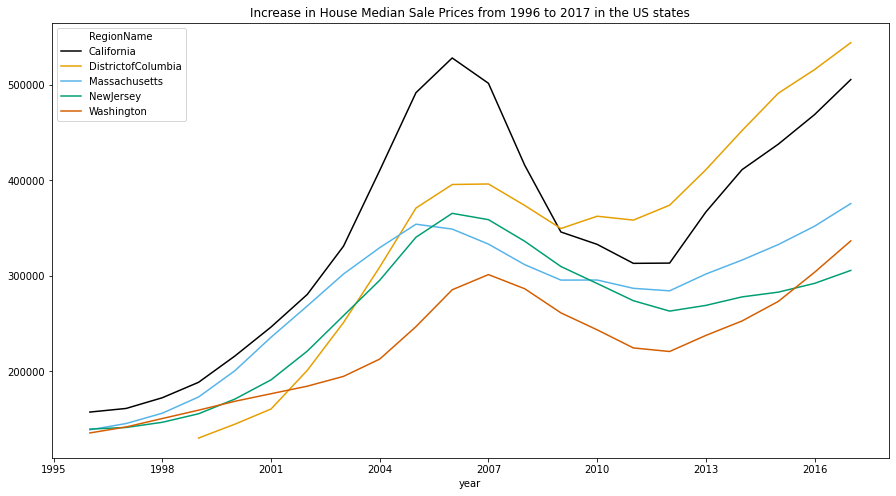

In [5]:
# Colorblind-friendly colors
# distribution of sold price 
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]


States_year_SalePrices=State_time_series_year.groupby([State_time_series_year.year,State_time_series_year.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='SoldPrice')
fte_graph=States_year_SalePrices.pivot(index='year', columns='RegionName', values='SoldPrice').plot(figsize=(15,8), color=colors, legend=True,title = 'Increase in House Median Sale Prices from 1996 to 2017 in the US states')
fte_graph.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

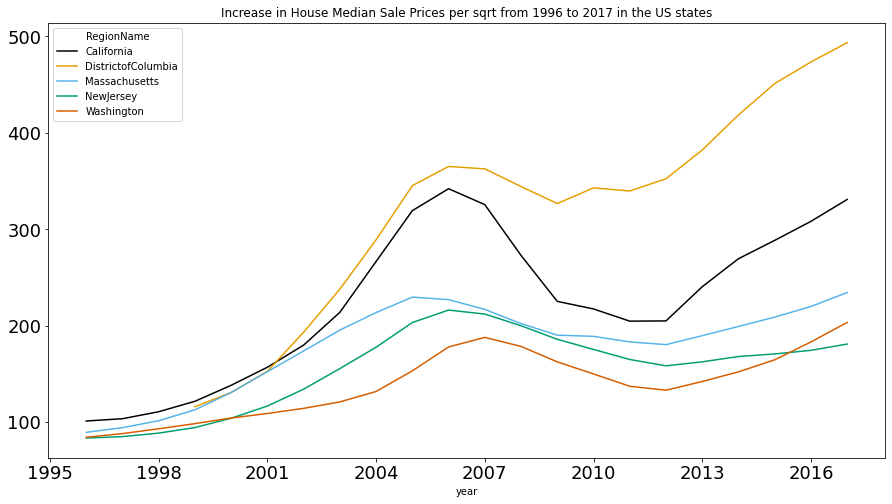

In [ ]:
#distribution for housing prices per square foot
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]


States_year_SalePrices=State_time_series_year.groupby([State_time_series_year.year,State_time_series_year.RegionName])['ZHVIPerSqft_AllHomes'].mean().dropna().reset_index(name='SoldPrice')
fte_graph=States_year_SalePrices.pivot(index='year', columns='RegionName', values='SoldPrice').plot(figsize=(15,8), color=colors, legend=True,title = 'Increase in House Median Sale Prices per sqrt from 1996 to 2017 in the US states')
fte_graph.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)


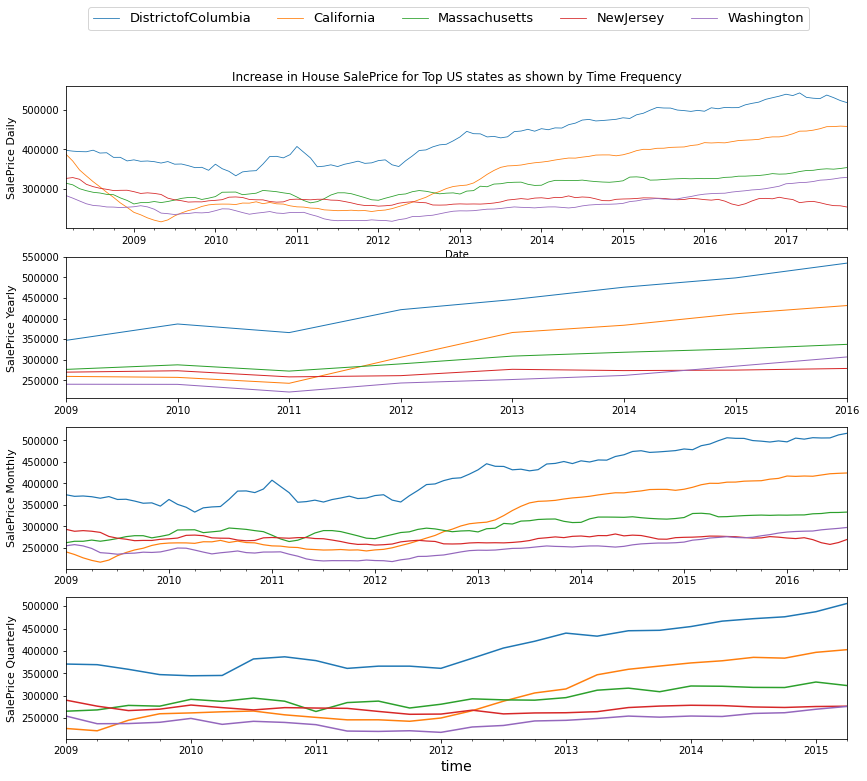

In [6]:
States_year_SalePrices=State_time_series_year.groupby([State_time_series_year.Date,State_time_series_year.RegionName])['Sale_Prices'].mean().dropna().reset_index(name='Sale_Prices')
PriceDF=States_year_SalePrices.pivot(index='Date', columns='RegionName', values='Sale_Prices').dropna()#.plot(figsize=(15,8))#, color=colors, legend=False)

t0 = PriceDF.index
t1 = pd.date_range(pd.to_datetime('30/01/2009'),pd.to_datetime('2017-08-31'),freq='A')
t2 = pd.date_range(pd.to_datetime('30/01/2009',dayfirst=True),pd.to_datetime('2016-08-31' ,dayfirst=True),freq='M')
t3 = pd.date_range(pd.to_datetime('30/01/2009',dayfirst=True),pd.to_datetime('2015-08-31',dayfirst=True),freq='Q')



fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,12))
ax[0].set_title("Increase in House SalePrice for Top US states as shown by Time Frequency")
PriceDF.reindex(index=t0,columns=highest_cost_states).plot(ax=ax[0], lw=0.8, legend=False);
#ax[0].set_xlabel('Year')
ax[0].set_ylabel('SalePrice Daily', fontsize=11)
PriceDF.reindex(index=t1,columns=highest_cost_states).plot(ax=ax[1], lw=1.0, legend=False);
ax[1].set_ylabel('SalePrice Yearly', fontsize=11)

PriceDF.reindex(index=t2,columns=highest_cost_states).plot(ax=ax[2], lw=1.2, legend=False); 
ax[2].set_ylabel('SalePrice Monthly', fontsize=11)

PriceDF.reindex(index=t3,columns=highest_cost_states).plot(ax=ax[3], lw=1.5, legend=False);
ax[3].set_ylabel('SalePrice Quarterly', fontsize=11)


ax[0].legend(loc='lower left',fontsize=13, bbox_to_anchor=(0.02,1.35), ncol=len(highest_cost_states));
ax[3].set_xlabel('time', fontsize=14);

In [7]:
#running through an example of state Washington
#find the log zhvi prices per square foot 
state = ['Washington']
state_zhvi_data = State_time_series_year[['Date','ZHVIPerSqft_AllHomes','RegionName']]
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName.isin(state)]
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVIPerSqft_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')

In [8]:
#split test and train set
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015]

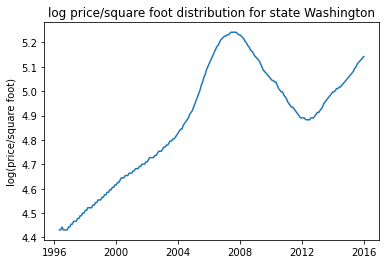

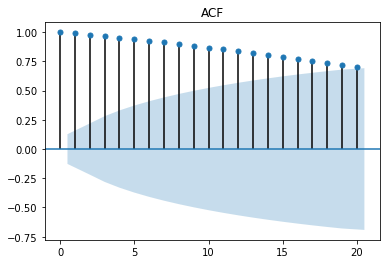

<Figure size 432x288 with 0 Axes>

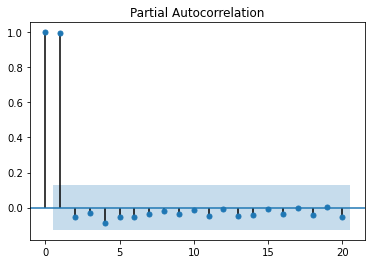

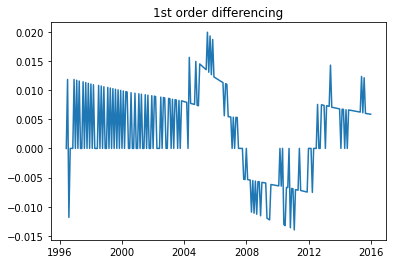

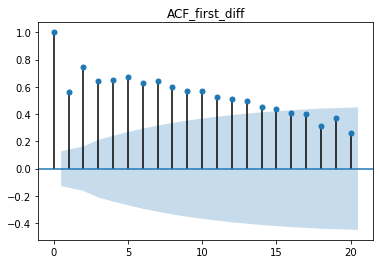

<Figure size 432x288 with 0 Axes>

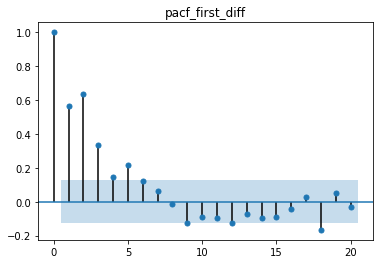

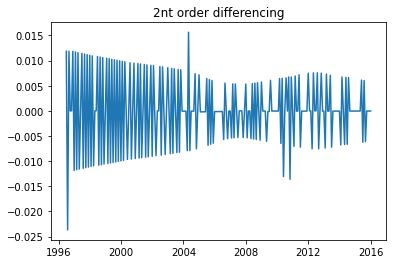

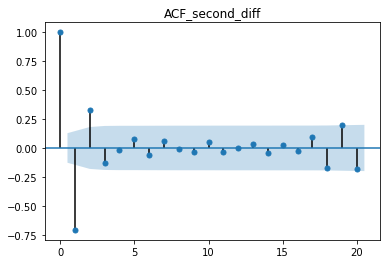

<Figure size 432x288 with 0 Axes>

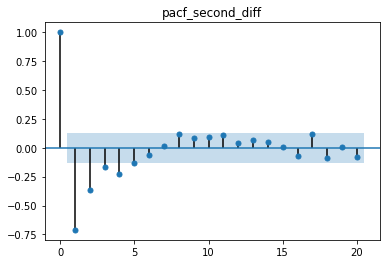

In [9]:
#plot distribution and its acf for 2 order differencing
lag = 20
plt.title('log price/square foot distribution for state Washington')
plt.ylabel('log(price/square foot)')
plt.plot(train)
plot_acf(x=train, lags=lag, title="ACF")


plt.show()
plt.figure()
sm.graphics.tsa.plot_pacf(train, lags=lag)
plt.show()

plt.plot(train.diff())
plt.title('1st order differencing')
plt.show()



plot_acf(train.diff().dropna(),lags = lag, title = 'ACF_first_diff')
plt.show()

plt.figure()
sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=lag,title = 'pacf_first_diff')
plt.show()

plt.plot(train.diff().diff().dropna())
plt.title('2nt order differencing')
plt.show()

plot_acf(train.diff().diff().dropna(),lags = lag, title = 'ACF_second_diff')
plt.show()

plt.figure()
sm.graphics.tsa.plot_pacf(train.diff().diff().dropna(), lags=lag,title = 'pacf_second_diff')
plt.show()


In [11]:
#fit the arima model
arma_mod = sms.tsa.arima.model.ARIMA(train, order = (1,2,1)).fit()
#arma_mod = sms.tsa.arima_model.ARIMA(train, order = (1,2,1)).fit()
print(arma_mod.params)


ar.L1    -0.468474
ma.L1    -0.535073
sigma2    0.000019
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



In [12]:
#get the predicted time
future_time = arma_mod.predict('2016','2018',dynamic = True)[:-1].index

In [13]:
#find the rmse
np.sqrt(mean_squared_error(test,arma_mod.predict('2016','2018',dynamic = True)[:-1]))

0.0478385511767234

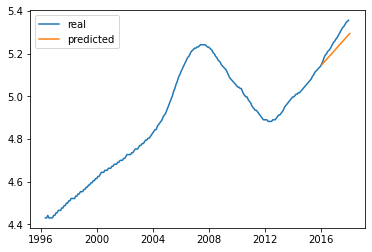

In [14]:
plt.plot(state_zhvi_data,label = 'real')
plt.plot(arma_mod.predict('2016','2018',dynamic = True),label = 'predicted')
plt.legend()

DistrictofColumbia


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



the mean sqare error for the existing prediction is 0.030937048863160684


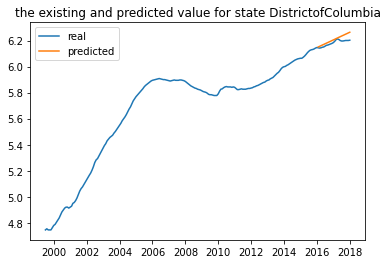

California


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



the mean sqare error for the existing prediction is 0.016612655532194744


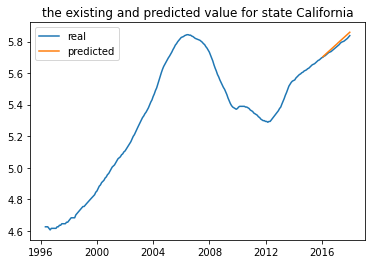

Massachusetts


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



the mean sqare error for the existing prediction is 0.005365486460352762


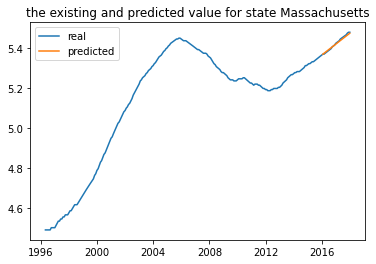

NewJersey


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



the mean sqare error for the existing prediction is 0.006684753521094625


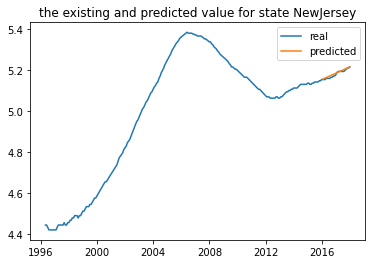

Washington


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



the mean sqare error for the existing prediction is 0.0478385511767234


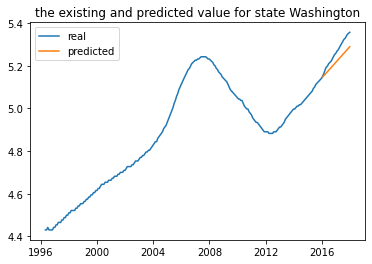

In [17]:
#fit arima model
#highest_cost_states vs log zhvi sqrt price
for state in highest_cost_states:
  print(state)
  state_zhvi_data = State_time_series_year[['Date','ZHVIPerSqft_AllHomes','RegionName']].dropna()
  #find the corresponding state 
  state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
  #get the date and its housing price
  state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVIPerSqft_AllHomes'])
  state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
  state_zhvi_data = state_zhvi_data.set_index('Date')
  train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
  test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
  # p = 4
  # q = 0
  # d = 1
  # arma_mod = sm.tsa.ARMA(state_zhvi_data, (p,d,q)).fit(disp=False)
  model = pm.auto_arima(train, seasonal=False, m=12)
  future_pred = model.predict(24)
  mse = np.sqrt(mean_squared_error(test,future_pred[:24]))
  print('the mean sqare error for the existing prediction is {}'.format(mse))  
  plt.plot(state_zhvi_data,label = 'real')
  plt.plot(future_time,future_pred,label = 'predicted')
  plt.title('the existing and predicted value for state {}'.format(state))
  plt.legend()
  plt.show()

In [ ]:
SCAL = [0.5**2, 1, 2, 2]
def kernel(ss):
    kernel = ss[0]*DotProduct()*ExpSineSquared(periodicity = 1) + ss[1]*RBF(length_scale=1.0, length_scale_bounds=(0.0, 10.0))
    return kernel

In [ ]:
SCAL1 = [100, 1000, 200, 200]
def kernel1(ss):
    kernel = ss[1]*RBF(length_scale=80.0, length_scale_bounds=(0.0, 10.0)) + ss[3]*RBF(length_scale=100)*ExpSineSquared(periodicity = 150)
    return kernel

DistrictofColumbia


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



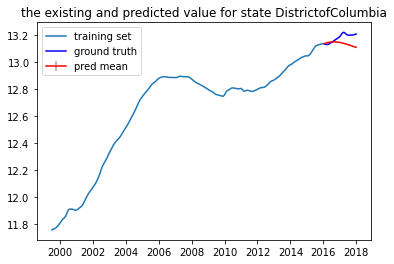

rmse = 0.057809374450217006
California


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log



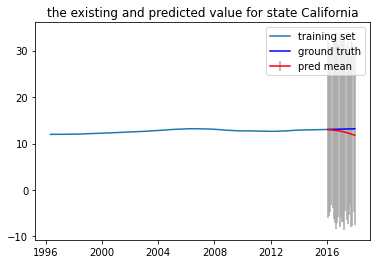

rmse = 0.7040719613762374
Massachusetts


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



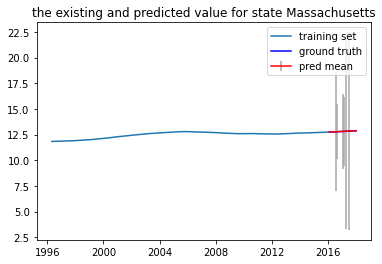

rmse = 0.008160691022114898
NewJersey


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



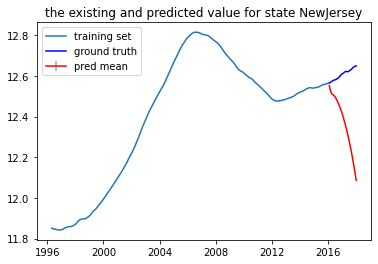

rmse = 0.2856302173782675
Washington


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



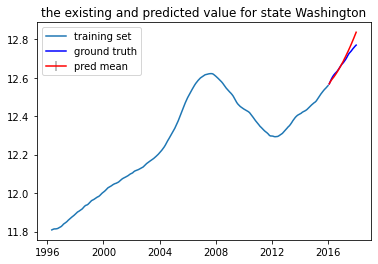

rmse = 0.026067220630044137


In [ ]:
#fig, ax = plt.subplots(len(SCAL), 1, figsize=(10,14))
for state in highest_cost_states:
  print(state)
  state_zhvi_data = State_time_series_year[['Date','ZHVI_AllHomes','RegionName']].dropna()
  #find the corresponding state 
  state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
  #get the date and its housing price
  state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVI_AllHomes'])
  state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
  state_zhvi_data = state_zhvi_data.set_index('Date')
  train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
  test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
  gp = GaussianProcessRegressor(kernel=kernel(SCAL))
  gp.fit(np.arange(len(train)).reshape(-1, 1), train)

  mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

  plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                label="pred mean")
  # gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
  # gp.fit(np.arange(len(train)).reshape(-1, 1), train)
  # mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
  # plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
  #              label="pred mean")
  plt.plot(train.index.values,train,label = 'training set')
  plt.plot(test.index.values,test, "b-", label="ground truth")
  plt.title('the existing and predicted value for state {}'.format(state))
  plt.legend()
  plt.show()
  #plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
  print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



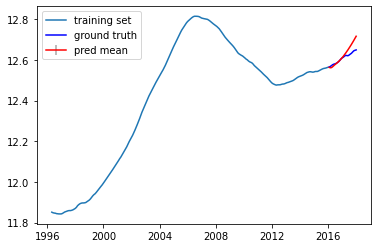

rmse = 0.028258377678710186


In [ ]:
SCAL = [0.1, 1, 2, 2]
def kernel(ss):
    kernel =  ss[1]*RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))+ss[3]*RBF(length_scale=150)*ExpSineSquared(periodicity = 80) + ss[0]*DotProduct(1.5)
    return kernel
state = 'NewJersey'
state_zhvi_data = State_time_series_year[['Date','ZHVI_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVI_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning:

Predicted variances smaller than 0. Setting those variances to 0.



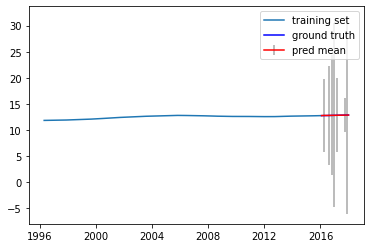

rmse = 0.011203945844089574


In [ ]:
SCAL = [0.5**2, 1, 0.8**2, 2]
def kernel(ss):
    kernel = ss[0]*DotProduct() + ss[2]*RBF(length_scale=150)*ExpSineSquared(periodicity = 1) + ss[1]*RBF(length_scale=1.0, length_scale_bounds=(0.0, 10.0))
    return kernel
state = 'Massachusetts'
state_zhvi_data = State_time_series_year[['Date','ZHVI_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVI_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



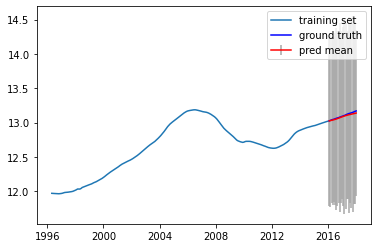

rmse = 0.014697544567886496


In [ ]:
SCAL = [0.1, 0.5**2, 2, 2]
def kernel(ss):
    kernel =  ss[1]*RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))+ss[3]*RBF(length_scale=150)*ExpSineSquared(periodicity = 80) + ss[0]*DotProduct(1.5)
    return kernel
state = 'California'
state_zhvi_data = State_time_series_year[['Date','ZHVI_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVI_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log



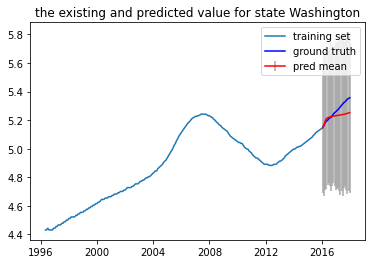

rmse = 0.05564101926518913


In [ ]:
SCAL = [1, 0.35**2, 2, 2]
def kernel(ss):
    kernel = ss[0]*DotProduct(sigma_0=4) + ss[1]*ExpSineSquared(periodicity = 12) + ss[1]*RBF(length_scale=1.0, length_scale_bounds=(0.0, 10.0))
    return kernel
state = 'Washington'
state_zhvi_data = State_time_series_year[['Date','ZHVIPerSqft_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVIPerSqft_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.title('the existing and predicted value for state {}'.format(state))
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log



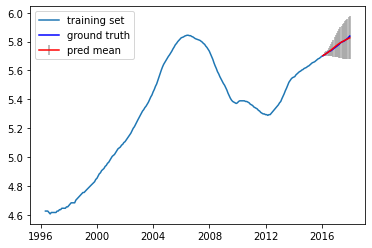

rmse = 0.004428321596709065


In [ ]:
SCAL = [0.1, 0.5**2, 2, 2]
def kernel(ss):
    kernel =  ss[1]*RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))+ss[3]*RBF(length_scale=150)*ExpSineSquared(periodicity = 80) + ss[0]*DotProduct(1.5)
    return kernel
state = 'California'
state_zhvi_data = State_time_series_year[['Date','ZHVIPerSqft_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVIPerSqft_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning:

divide by zero encountered in log



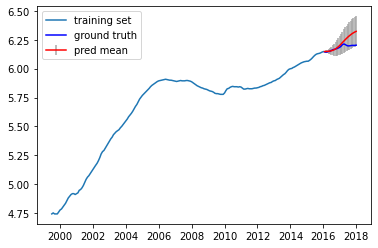

rmse = 0.057249778005831725


In [ ]:
SCAL = [0.1, 0.5**2, 2, 3]
def kernel(ss):
    kernel =  ss[1]*RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))+ss[3]*RBF(length_scale=150)*ExpSineSquared(periodicity = 180) + ss[0]*DotProduct(1.5)
    return kernel
state = 'DistrictofColumbia'
state_zhvi_data = State_time_series_year[['Date','ZHVIPerSqft_AllHomes','RegionName']].dropna()
#find the corresponding state 
state_zhvi_data = state_zhvi_data.loc[state_zhvi_data.RegionName == state]
#get the date and its housing price
state_zhvi_data['logzhvi'] = np.log(state_zhvi_data['ZHVIPerSqft_AllHomes'])
state_zhvi_data = state_zhvi_data[['Date','logzhvi']]
state_zhvi_data = state_zhvi_data.set_index('Date')
train = state_zhvi_data[state_zhvi_data.index.year <= 2015]
test = state_zhvi_data[state_zhvi_data.index.year > 2015] 
gp = GaussianProcessRegressor(kernel=kernel(SCAL))
gp.fit(np.arange(len(train)).reshape(-1, 1), train)

mus, sigma = gp.predict(np.arange(len(train),len(train)+len(test)).reshape(-1, 1), return_std=True)

plt.errorbar(test.index.values,mus,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
              label="pred mean")
# gp = GaussianProcessRegressor(kernel=kernel1(SCAL1))
# gp.fit(np.arange(len(train)).reshape(-1, 1), train)
# mu,sigma = gp.predict(np.arange(24).reshape(-1,1),return_std = True)
# plt.errorbar(future_time,mu,yerr = sigma,capsize = 0, ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
#              label="pred mean")
plt.plot(train.index.values,train,label = 'training set')
plt.plot(test.index.values,test, "b-", label="ground truth")
plt.legend()
plt.show()
#plot_gp(test.index.values, mus, sigma, train.index.values, train, test, ax=ax[ss])
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, test))))